In [2]:
import xarray
import xroms
from xhistogram.xarray import histogram
from xrspatial.convolution import convolution_2d

import matplotlib.pyplot as plt
import numpy as np

from bichan_utils import *
from glob import glob

import warnings
warnings.filterwarnings('ignore')

In [3]:
rootdir = '/global/cfs/cdirs/m4304/roms_channel/test_cases/'

In [4]:
cases = ['200m', '500m', '1km', '2km', '5km', '10km']
ncfiles = [rootdir + 'res_' + case + '/roms_his.nc' for case in cases]

In [5]:
def load_dataset(ncfile):
    ds = xarray.open_dataset(ncfile, chunks={'ocean_time': 1})
    ds, _ = xroms.roms_dataset(ds)
    ds = add_derivatives(ds)
    ds = ds.isel(s_rho=-1)
    return ds

dss = [load_dataset(ncfile) for ncfile in ncfiles]

In [6]:

class grad_vel_histogram(object):
    
    def __init__(self, ds):
        if np.allclose(ds.pn, 0.005):
            tslice = {'ocean_time': slice(120, 201)}
        else:
            tslice = {'ocean_time': slice(72, 120)}

        conditional = (ds.zeta.isel(tslice) > 0.0) & (ds.y_rho > 50e3) & (ds.y_rho < 250e3)

        xbins = np.linspace(-3, 3, 201)
        ybins = np.linspace(-5, 3, 201)
       
        self.h = histogram(ds.du_cf.isel(tslice).where(conditional),
                      ds.du_af.isel(tslice).where(conditional), 
                      bins=[ybins, xbins]).compute()

        self.X = np.asarray([ds.du_cf.isel(tslice).where(conditional).values,
                        ds.du_af.isel(tslice).where(conditional).values])

    def calc_pca(self):
        X = self.X
        
        # remove nans and flatten time and spacial dims
        idx = ~np.isnan(X[0]) & ~np.isinf(X[0]) & ~np.isnan(X[1]) & ~np.isinf(X[1])
        X = X[:, idx]

        e, v = np.linalg.eig(np.cov(X-X.mean(axis=1, keepdims=True)))

        # The distribution mean in x & y
        self.yo, self.xo = X.mean(axis=1)

        # The major/minor axis of variation, as a vector centered at 0,0
        self.v_major = [np.sqrt(e[0])*v[1, 0], np.sqrt(e[0])*v[0, 0]]
        self.v_minor = [np.sqrt(e[1])*v[1, 1], np.sqrt(e[1])*v[0, 1]]

        # The angle of the major axis, relative to the positive y-axis, positive CCW
        # In this case, pi/4 represents straining flow, 0 represents divergent flow
        self.theta = np.arctan(v[1, 0]/v[0, 0])
    
hists = [grad_vel_histogram(ds) for ds in dss]

In [7]:
[hist.calc_pca() for hist in hists]

[None, None, None, None, None, None]

200m -4.112030969691368 2.6459778068721564 -0.3490957811079572
500m -7.925211538241434 2.2031368422947164 -0.3336155363474885
1km -12.546538127978232 2.0600994833642465 -0.286255234994982
2km -18.948344807617378 1.8901440306468864 -0.24438129583881232
5km -27.792492875691906 1.6486248882095653 -0.14189519401520062
10km -36.46775391602715 1.6242345460497416 -0.05770580697161287


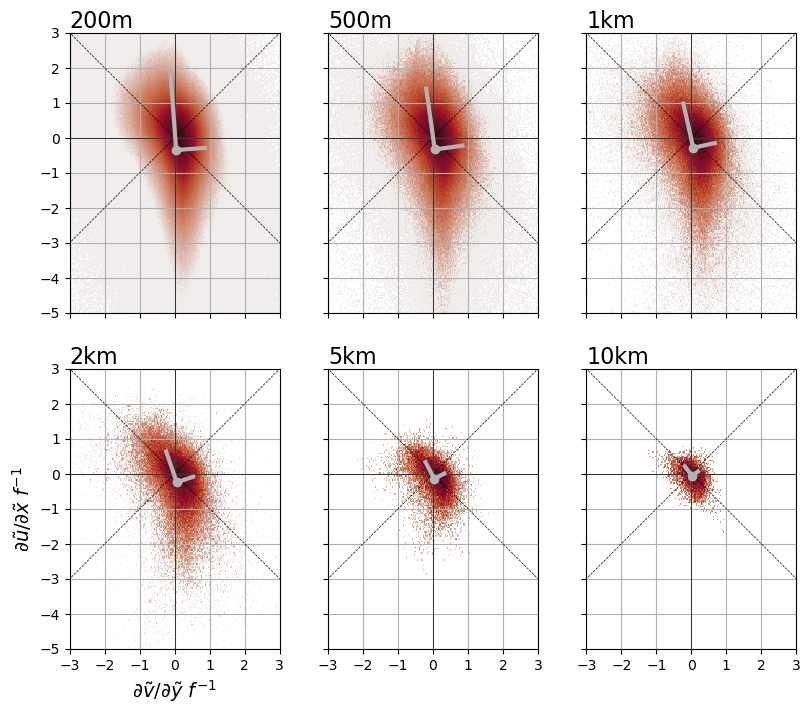

In [8]:
def plot_hist(h, case, ax=None):
    
    if not ax:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111)

    pc = np.log10(h.h/h.h.max()).plot(cmap=cmo.amp, ax=ax, add_colorbar=False)
    pc.set_clim(-2, 0)
    
    xo, yo = h.xo, h.yo
    
    ax.plot([-3, 3], [0, 0], '-k', lw=0.5)
    ax.plot([0, 0], [-5, 3], '-k', lw=0.5)
    ax.plot([0, 3], [0, 3], '--k', lw=0.5)
    ax.plot([0, -3], [0, 3], '--k', lw=0.5)
    ax.plot([0, 3], [0, -3], '--k', lw=0.5)
    ax.plot([0, -3], [0, -3], '--k', lw=0.5)
    
    ax.plot(xo, yo, 'o', color='0.7')
    ax.plot([xo, xo+h.v_major[0]], [yo, yo+h.v_major[1]], '-', color='0.7', lw=3)
    ax.plot([xo, xo+h.v_minor[0]], [yo, yo+h.v_minor[1]], '-', color='0.7', lw=3)
    ax.text(0.0, 1.0, case, 
            horizontalalignment='left',
            verticalalignment='bottom', 
            transform=ax.transAxes, fontsize=16)
    ratio = np.sqrt((np.array(h.v_major)**2).sum())/np.sqrt((np.array(h.v_minor)**2).sum())
    if ratio < 1:
        ratio = 1/ratio
    phi = np.arctan(h.v_major[0]/h.v_major[1]) * 180/np.pi
    # ax.text(0.03, 0.03, f'$\\phi_{{PCA}}$ {phi:.1f}$^\\circ$\nmajor/minor ratio = {ratio:.3f}\nmean($\\partial\\tilde{{u}}/\\partial\\tilde{{x}}$) = {yo:.3f}', 
    #         horizontalalignment='left',
    #         verticalalignment='bottom', 
    #         transform=ax.transAxes, fontsize=11)
    ax.set_xticks(np.arange(-3, 4))
    if case is '2km':
        ax.set_ylabel(r'$\partial{}\tilde{u}/\partial{}\tilde{x}$ $f^{-1}$', fontsize=14)
        ax.set_xlabel(r'$\partial{}\tilde{v}/\partial{}\tilde{y}$ $f^{-1}$', fontsize=14)
    else:
        ax.set_ylabel('')
        ax.set_xlabel('')
    
    print(case, phi, ratio, yo)
    
    ax.grid(True)
    ax.set_aspect(1.0)

print ('Data for Table 1')
print (
print ('res, theta_PCA,       , major/minor ratio, mean FGF') 
# fig, axs = plt.subplots(1, 6, figsize=(30, 6), sharey=True, gridspec_kw={'wspace': 0.1})
fig, axs = plt.subplots(2, 3, figsize=(10, 8), sharex=True, sharey=True, gridspec_kw={'wspace': 0.0})
[plot_hist(h, case, ax) for h, case, ax in zip(hists, cases, axs.flatten())]
fig.savefig('frontal_velocity_gradient_histograms.png', dpi=300)

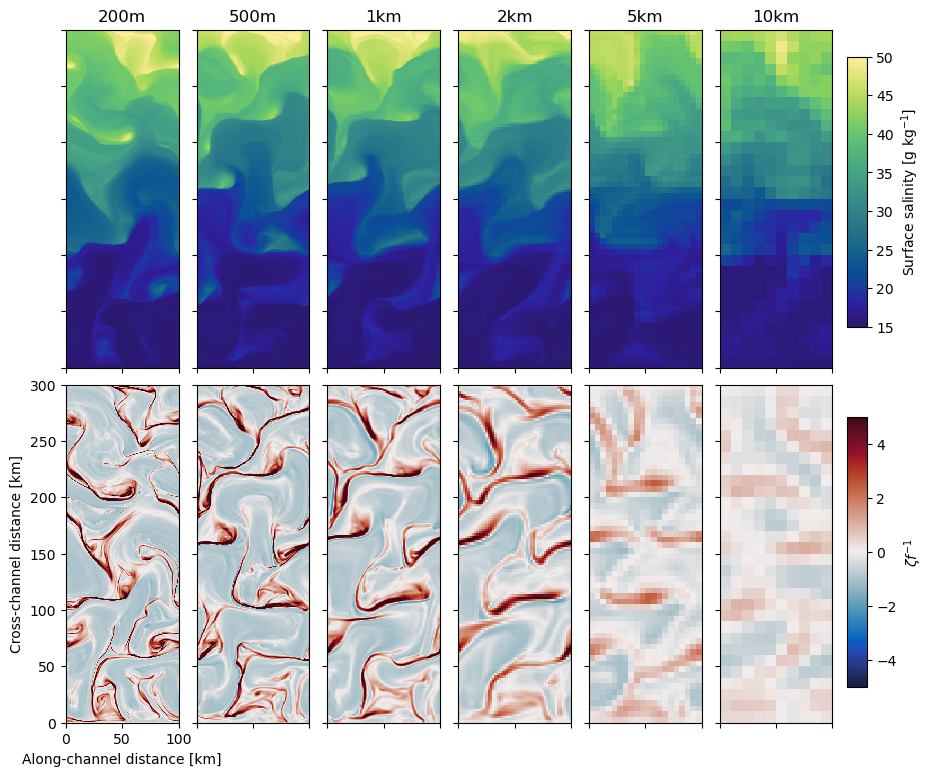

In [10]:
def plot_sss(ds, ax):
    if np.allclose(ds.pn, 0.005):
        tidx = 120+60
    else:
        tidx = 72+36
    pc = ax.pcolormesh(ds.x_psi.values/1e3, ds.y_psi.values/1e3, 
                   ds.salt.isel(ocean_time=tidx).values[1:-1, 1:-1], cmap=cmo.haline,
                   vmin=15, vmax=50)
    ax.set_aspect(1.0)
    return pc

    
def plot_zeta(ds, ax):
    if np.allclose(ds.pn, 0.005):
        tidx = 120+60
    else:
        tidx = 72+36
    pc = ax.pcolormesh(ds.x_psi.values/1e3, ds.y_psi.values/1e3, 
                   ds.zeta.isel(ocean_time=tidx).values[1:-1, 1:-1], cmap=cmo.balance,
                   vmin=-5, vmax=5)
    ax.set_aspect(1.0)
    return pc

fig, axs = plt.subplots(2, 6, figsize=(10, 9), gridspec_kw={'wspace': 0.08, 'hspace': 0.05})
for col in range(6):
    pcs = plot_sss(dss[col], axs[0, col])
    pcz = plot_zeta(dss[col], axs[1, col])
    axs[0, col].set_title(cases[col])
    axs[0, col].set_xticklabels([])
    axs[1, col].set_xticklabels([])
    axs[0, col].set_yticklabels([])
    axs[1, col].set_yticklabels([])
    

axcbs = fig.add_axes([0.91, 0.55, 0.02, 0.3])
plt.colorbar(pcs, cax=axcbs).set_label(r'Surface salinity [g kg$^{-1}$]')

axcbz = fig.add_axes([0.91, 0.15, 0.02, 0.3])
plt.colorbar(pcz, cax=axcbz).set_label(r'$\zeta f^{-1}$')

axs[1, 0].set_xlabel('Along-channel distance [km]')
axs[1, 0].set_ylabel('Cross-channel distance [km]')
axs[1, 0].set_xticklabels(np.arange(0, 400, 50))
axs[1, 0].set_yticklabels(np.arange(0, 400, 50))

fig.savefig('idealized_surface_properties.png', dpi=300)

In [11]:
hist.__dict__

NameError: name 'hist' is not defined